In [1]:
import cv2
import numpy as np
from PIL import Image, ImageEnhance

table_image = cv2.imread(r"C:\Users\weili\test\Screenshot 2023-12-18 154231.png")

def preprocess(img, factor: int):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = Image.fromarray(img)
    enhancer = ImageEnhance.Sharpness(img).enhance(factor)
    if gray.std() < 30:
        enhancer = ImageEnhance.Contrast(enhancer).enhance(factor)
    return np.array(enhancer)

gray = cv2.cvtColor(table_image, cv2.COLOR_BGR2GRAY)
thresh, img_bin = cv2.threshold(
    gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
img_bin = 255-img_bin

kernel_len = gray.shape[1]//120
hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))
image_horizontal = cv2.erode(img_bin, hor_kernel, iterations=3)
horizontal_lines = cv2.dilate(image_horizontal, hor_kernel, iterations=3)

h_lines = cv2.HoughLinesP(
    horizontal_lines, 1, np.pi/180, 30, maxLineGap=250)

In [2]:
kernel_len = gray.shape[1]//120
ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))
image_vertical = cv2.erode(img_bin, ver_kernel, iterations=3)
vertical_lines = cv2.dilate(image_vertical, ver_kernel, iterations=3)

v_lines = cv2.HoughLinesP(vertical_lines, 1, np.pi/180, 30, maxLineGap=250)

def group_v_lines(v_lines, thin_thresh):
    new_v_lines = []
    while len(v_lines) > 0:
        thresh = sorted(v_lines, key=lambda x: x[0][0])[0][0]
        lines = [line for line in v_lines if thresh[0] -
                 thin_thresh <= line[0][0] <= thresh[0] + thin_thresh]
        v_lines = [line for line in v_lines if thresh[0] - thin_thresh >
                   line[0][0] or line[0][0] > thresh[0] + thin_thresh]
        y = []
        for line in lines:
            y.append(line[0][1])
            y.append(line[0][3])
        y_min, y_max = min(y) - int(4*thin_thresh), max(y) + int(4*thin_thresh)
        new_v_lines.append([thresh[0], y_min, thresh[0], y_max])
    return new_v_lines
    
new_vertical_lines = group_v_lines(v_lines, kernel_len)

In [3]:
import numpy as np
def draw_white_lines(image, lines):
    for line in lines:
        x1, y1, x2, y2 = line
        cv2.line(image, (x1, y1), (x2, y2), (255, 255, 255), 2) 



draw_white_lines(table_image, new_vertical_lines)

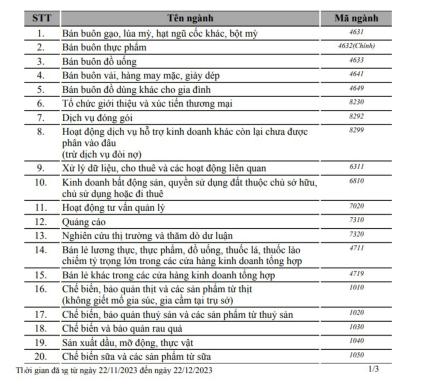

In [4]:
import matplotlib.pyplot as plt

# Save the image with the red lines to a file
cv2.imwrite('new_one.jpg', table_image)
# Display the saved image using Matplotlib
img = cv2.imread('new_one.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.axis('off')  # Turn off axis labels
plt.show()

In [5]:
def group_h_lines(h_lines, thin_thresh):
    new_h_lines = []
    while len(h_lines) > 0:
        thresh = sorted(h_lines, key=lambda x: x[0][1])[0][0]
        lines = [line for line in h_lines if thresh[1] -
                 thin_thresh <= line[0][1] <= thresh[1] + thin_thresh]
        h_lines = [line for line in h_lines if thresh[1] - thin_thresh >
                   line[0][1] or line[0][1] > thresh[1] + thin_thresh]
        x = []
        for line in lines:
            x.append(line[0][0])
            x.append(line[0][2])
        x_min, x_max = min(x) - int(5*thin_thresh), max(x) + int(5*thin_thresh)
        new_h_lines.append([x_min, thresh[1], x_max, thresh[1]])
    return new_h_lines
    
new_horizontal_lines = group_h_lines(h_lines, kernel_len)


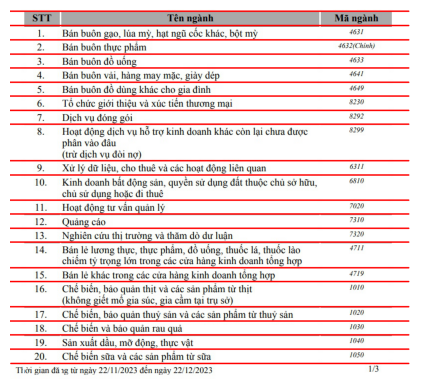

In [6]:
import numpy as np
def draw_red_lines(image, lines):
    for line in lines:
        x1, y1, x2, y2 = line
        cv2.line(image, (x1, y1), (x2, y2), (0, 0, 255), 2) 



draw_red_lines(img, new_horizontal_lines)

img_with_red_lines = img.copy()

# Draw red lines on the image
draw_red_lines(img_with_red_lines, new_horizontal_lines)

# Convert BGR to RGB for Matplotlib
img_rgb = cv2.cvtColor(img_with_red_lines, cv2.COLOR_BGR2RGB)

# Display the image with red lines using Matplotlib
plt.imshow(img_rgb)
plt.axis('off')  # Turn off axis labels
plt.show()

In [8]:
new_horizontal_lines

[[0, 4, 808, 4],
 [0, 33, 808, 33],
 [0, 62, 808, 62],
 [0, 91, 808, 91],
 [0, 119, 808, 119],
 [0, 148, 808, 148],
 [0, 176, 808, 176],
 [0, 205, 808, 205],
 [0, 233, 808, 233],
 [0, 307, 808, 307],
 [0, 336, 808, 336],
 [0, 387, 808, 387],
 [0, 415, 808, 415],
 [0, 444, 808, 444],
 [0, 472, 808, 472],
 [0, 524, 808, 524],
 [0, 552, 808, 552],
 [0, 603, 808, 603],
 [0, 632, 808, 632],
 [0, 660, 808, 660],
 [0, 689, 808, 689],
 [1, 718, 808, 718]]

In [10]:
import cv2
import os
# Example image path
image_path = r"C:\Users\weili\test\new_one.jpg"


# Check if the image is loaded successfully
if table_image is None:
    print("Error: Unable to load the image.")
else:
    # Your cropping and saving logic here
    count = 1  # Set an initial count value
    for i in range(0, len(new_horizontal_lines)-1):
        top_line = new_horizontal_lines[i]
        bottom_line = new_horizontal_lines[i+1]

        xmin_top, ymin_top, xmax_top, ymax_top = top_line
        xmin_bottom, ymin_bottom, xmax_bottom, ymax_bottom = bottom_line

        # Crop the image using the top and bottom edges
        cropped_image = table_image[ymin_top:ymax_bottom, xmin_top:xmax_top]

        if cropped_image is not None and cropped_image.size > 0:
            # Extract the filename without the path
            filename = os.path.basename(image_path)

            # Save the cropped image with the specified format
            save_path = fr"C:\Users\weili\test\new\{count}__{filename}"
            cv2.imwrite(save_path, cropped_image)

            count += 1  # Increment the count for the next iteration
            print(f"Image cropped and saved successfully at: {save_path}")
        else:
            print("Error: Cropped image is empty.")

Image cropped and saved successfully at: C:\Users\weili\test\new\1__new_one.jpg
Image cropped and saved successfully at: C:\Users\weili\test\new\2__new_one.jpg
Image cropped and saved successfully at: C:\Users\weili\test\new\3__new_one.jpg
Image cropped and saved successfully at: C:\Users\weili\test\new\4__new_one.jpg
Image cropped and saved successfully at: C:\Users\weili\test\new\5__new_one.jpg
Image cropped and saved successfully at: C:\Users\weili\test\new\6__new_one.jpg
Image cropped and saved successfully at: C:\Users\weili\test\new\7__new_one.jpg
Image cropped and saved successfully at: C:\Users\weili\test\new\8__new_one.jpg
Image cropped and saved successfully at: C:\Users\weili\test\new\9__new_one.jpg
Image cropped and saved successfully at: C:\Users\weili\test\new\10__new_one.jpg
Image cropped and saved successfully at: C:\Users\weili\test\new\11__new_one.jpg
Image cropped and saved successfully at: C:\Users\weili\test\new\12__new_one.jpg
Image cropped and saved successfully 

In [20]:
import os
import pytesseract

custom_config = r'--oem 3 --psm 6'  # Adjust parameters based on your needs

folder_path = r"C:\Users\weili\test\new"

ocr_results = []

# Iterate through each file in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith(('.png', '.jpg', '.jpeg')):
        # Full path to the image file
        image_path = os.path.join(folder_path, file_name)

        # Read the image
        table_image = cv2.imread(image_path)

        # Check if the image is loaded successfully
        if table_image is not None:
            # Perform OCR using pytesseract on the image
            image_pil = Image.fromarray(cv2.cvtColor(table_image, cv2.COLOR_BGR2RGB))
            text = pytesseract.image_to_string(image_pil, lang='vie')  # Specify the language for both Vietnamese and English

            # Append the OCR result to the list
            ocr_results.append({text})

            # Print or save the OCR result as needed
            print(f"OCR Result for {image_path}:\n{text}")
        else:
            print(f"Error: Unable to load the image {image_path}")

# Print the complete list of OCR results
print("\nComplete OCR Results:")


OCR Result for C:\Users\weili\test\new\10__new_one.jpg:
9 Xử lý dữ liệu, cho thuê và các hoạt động liên quan 611

OCR Result for C:\Users\weili\test\new\11__new_one.jpg:
10.  Kinh doanh bất động sản, quyền sử dụng đất thuộc chủ sở hữu, 6810
chủ sử dụng hoặc đi thuê

OCR Result for C:\Users\weili\test\new\12__new_one.jpg:
11.. Hoạt động tư vấn quản lý 7020

OCR Result for C:\Users\weili\test\new\13__new_one.jpg:
12... Quảng cáo 7310

OCR Result for C:\Users\weili\test\new\14__new_one.jpg:
13. Nghiên cứu thị trường và thăm dò dư luận 7320

OCR Result for C:\Users\weili\test\new\15__new_one.jpg:
14. - Bán lẻ lương thực, thực phẩm, đô uông, thuộc lá, thuốc lào n
chiếm tỷ trọng lớn trong các cửa hàng kinh doanh tổng hợp

OCR Result for C:\Users\weili\test\new\16__new_one.jpg:
15 Bán lẻ khác trong các cửa hàng kinh doanh tổng hợp 4719

OCR Result for C:\Users\weili\test\new\17__new_one.jpg:
16. Chếbiến, bảo quản thịt và các sản phẩm từ thịt L
(không giết mỗ gia súc, gia cầm tại trụ sở)

OCR 

In [19]:
ocr_results

[{'9 Xử lý dữ liệu, cho thuê và các hoạt động liên quan 611\n'},
 {'10.  Kinh doanh bất động sản, quyền sử dụng đất thuộc chủ sở hữu, 6810\nchủ sử dụng hoặc đi thuê\n'},
 {'11.. Hoạt động tư vấn quản lý 7020\n'},
 {'12... Quảng cáo 7310\n'},
 {'13. Nghiên cứu thị trường và thăm dò dư luận 7320\n'},
 {'14. - Bán lẻ lương thực, thực phẩm, đô uông, thuộc lá, thuốc lào n\nchiếm tỷ trọng lớn trong các cửa hàng kinh doanh tổng hợp\n'},
 {'15 Bán lẻ khác trong các cửa hàng kinh doanh tổng hợp 4719\n'},
 {'16. Chếbiến, bảo quản thịt và các sản phẩm từ thịt L\n(không giết mỗ gia súc, gia cầm tại trụ sở)\n'},
 {'17. Chế biến, bảo quản thuỷ sản và các sản phẩm từ thuỷ sản. 1020\n'},
 {'18. Chế biến và bảo quản rau quả 1030\n'},
 {'STT Tên ngành Mã ngành\n'},
 {'1040\n'},
 {'20.  Chế biến sữa và các sản phẩm từ sữa 1050\n'},
 {'Bán buôn gạo, lúa mỳ, hạt ngũ cốc khác, bột mỳ. 4631\n\n'},
 {'2 Bán buôn thực phâm 4632(Chính)\n'},
 {'3\n\nBán buôn đồ uống\n\n4633\n'},
 {'4 Bán buôn vải, hàng may mặc, 

In [22]:
import pandas as pd
df = pd.DataFrame(ocr_results)

In [23]:
df

,0
0,"9 Xử lý dữ liệu, cho thuê và các hoạt động liê..."
1,"10. Kinh doanh bất động sản, quyền sử dụng đấ..."
2,11.. Hoạt động tư vấn quản lý 7020\n
3,12... Quảng cáo 7310\n
4,13. Nghiên cứu thị trường và thăm dò dư luận 7...
5,"14. - Bán lẻ lương thực, thực phẩm, đô uông, t..."
6,15 Bán lẻ khác trong các cửa hàng kinh doanh t...
7,"16. Chếbiến, bảo quản thịt và các sản phẩm từ ..."
8,"17. Chế biến, bảo quản thuỷ sản và các sản phẩ..."
9,18. Chế biến và bảo quản rau quả 1030\n
